In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import seaborn as sns

In [2]:
data=pd.read_csv('ML_Data_48.csv')

In [3]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

In [4]:
x=data.drop(['label'], axis=1)
y=data['label']

In [5]:
scale=StandardScaler()
x=scale.fit_transform(x)

In [6]:
x_train, x_t, y_train, y_t= train_test_split(x,y,test_size=0.3, random_state=42)
x_train.shape, x_t.shape

((2614, 47), (1121, 47))

In [7]:
x_val, x_test, y_val, y_test= train_test_split(x_t, y_t, test_size=0.15, random_state=42)
x_val.shape, x_test.shape

((952, 47), (169, 47))

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import layers, models, optimizers

2024-08-18 03:23:18.088492: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-18 03:23:18.090487: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-18 03:23:18.128912: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 03:23:18.128939: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 03:23:18.128959: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [9]:
class TransformerEncoder(layers.Layer):
    def __init__(self, num_heads, ff_dim, input_dim, dropout_rate, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(input_dim)  # Match the input dimension for residual connection
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
    
    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build Transformer Model for Tabular Data
def build_transformer_model(input_dim, output_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate):
    inputs = layers.Input(shape=(input_dim,))
    
    # Reshape to 3D for multi-head attention
    x = layers.Reshape((1, input_dim))(inputs)
    
    # Stack Transformer Blocks
    for _ in range(num_transformer_blocks):
        x = TransformerEncoder(num_heads, ff_dim, input_dim, dropout_rate)(x)
    
    x = layers.Flatten()(x)
    
    # Output layer for classification
    outputs = layers.Dense(output_dim, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs)
    return model

In [10]:
# Hyperparameters
input_dim = x_train.shape[1]  # Number of features
output_dim = len(y_train.unique())  # Number of classes for classification
num_heads = 8
ff_dim = 64
num_transformer_blocks = 4
dropout_rate = 0.1
learning_rate = 0.001
batch_size = 32
num_epochs = 400

In [11]:
model = build_transformer_model(input_dim, output_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history=model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data= (x_val, y_val))

Epoch 1/400
82/82 [==============================] - 7s 18ms/step - loss: 1.5126 - accuracy: 0.4480 - val_loss: 1.3025 - val_accuracy: 0.5315
Epoch 2/400
82/82 [==============================] - 1s 11ms/step - loss: 1.2336 - accuracy: 0.5360 - val_loss: 1.1120 - val_accuracy: 0.5861
Epoch 3/400
82/82 [==============================] - 1s 10ms/step - loss: 1.1317 - accuracy: 0.5738 - val_loss: 1.0508 - val_accuracy: 0.6334
Epoch 4/400
82/82 [==============================] - 1s 10ms/step - loss: 1.0503 - accuracy: 0.6174 - val_loss: 1.0272 - val_accuracy: 0.6197
Epoch 5/400
82/82 [==============================] - 1s 10ms/step - loss: 0.9787 - accuracy: 0.6423 - val_loss: 1.0709 - val_accuracy: 0.6208
Epoch 6/400
82/82 [==============================] - 1s 11ms/step - loss: 0.9640 - accuracy: 0.6492 - val_loss: 1.0076 - val_accuracy: 0.6103
Epoch 7/400
82/82 [==============================] - 1s 11ms/step - loss: 0.9236 - accuracy: 0.6626 - val_loss: 0.9975 - val_accuracy: 0.6418
Epoch 

82/82 [==============================] - 1s 10ms/step - loss: 0.3410 - accuracy: 0.8730 - val_loss: 0.8123 - val_accuracy: 0.7500
Epoch 59/400
82/82 [==============================] - 1s 11ms/step - loss: 0.3378 - accuracy: 0.8795 - val_loss: 0.8548 - val_accuracy: 0.7574
Epoch 60/400
82/82 [==============================] - 1s 12ms/step - loss: 0.3218 - accuracy: 0.8826 - val_loss: 0.8201 - val_accuracy: 0.7668
Epoch 61/400
82/82 [==============================] - 1s 10ms/step - loss: 0.3168 - accuracy: 0.8837 - val_loss: 0.7909 - val_accuracy: 0.7731
Epoch 62/400
82/82 [==============================] - 1s 10ms/step - loss: 0.3208 - accuracy: 0.8841 - val_loss: 0.8374 - val_accuracy: 0.7784
Epoch 63/400
82/82 [==============================] - 1s 11ms/step - loss: 0.2962 - accuracy: 0.8852 - val_loss: 0.8575 - val_accuracy: 0.7668
Epoch 64/400
82/82 [==============================] - 1s 11ms/step - loss: 0.2781 - accuracy: 0.8998 - val_loss: 0.7871 - val_accuracy: 0.7857
Epoch 65/400

82/82 [==============================] - 1s 8ms/step - loss: 0.1756 - accuracy: 0.9380 - val_loss: 0.8904 - val_accuracy: 0.7784
Epoch 116/400
82/82 [==============================] - 1s 8ms/step - loss: 0.2266 - accuracy: 0.9166 - val_loss: 0.8773 - val_accuracy: 0.7815
Epoch 117/400
82/82 [==============================] - 1s 8ms/step - loss: 0.1882 - accuracy: 0.9304 - val_loss: 0.8274 - val_accuracy: 0.7983
Epoch 118/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1652 - accuracy: 0.9422 - val_loss: 0.9487 - val_accuracy: 0.7742
Epoch 119/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1699 - accuracy: 0.9384 - val_loss: 0.8044 - val_accuracy: 0.8046
Epoch 120/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1512 - accuracy: 0.9476 - val_loss: 0.9038 - val_accuracy: 0.7847
Epoch 121/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1576 - accuracy: 0.9453 - val_loss: 0.8730 - val_accuracy: 0.7931
Epoch 122/400

82/82 [==============================] - 1s 7ms/step - loss: 0.1504 - accuracy: 0.9438 - val_loss: 1.0357 - val_accuracy: 0.7847
Epoch 173/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1659 - accuracy: 0.9407 - val_loss: 0.9706 - val_accuracy: 0.7878
Epoch 174/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1140 - accuracy: 0.9572 - val_loss: 0.8576 - val_accuracy: 0.8046
Epoch 175/400
82/82 [==============================] - 1s 8ms/step - loss: 0.1141 - accuracy: 0.9583 - val_loss: 0.9560 - val_accuracy: 0.7826
Epoch 176/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1183 - accuracy: 0.9552 - val_loss: 0.9455 - val_accuracy: 0.7983
Epoch 177/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1410 - accuracy: 0.9526 - val_loss: 0.9456 - val_accuracy: 0.7868
Epoch 178/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1961 - accuracy: 0.9315 - val_loss: 1.0132 - val_accuracy: 0.7868
Epoch 179/400

82/82 [==============================] - 1s 8ms/step - loss: 0.1317 - accuracy: 0.9541 - val_loss: 0.9312 - val_accuracy: 0.7983
Epoch 230/400
82/82 [==============================] - 1s 7ms/step - loss: 0.0930 - accuracy: 0.9652 - val_loss: 1.0445 - val_accuracy: 0.7931
Epoch 231/400
82/82 [==============================] - 1s 8ms/step - loss: 0.0781 - accuracy: 0.9717 - val_loss: 0.9846 - val_accuracy: 0.7868
Epoch 232/400
82/82 [==============================] - 1s 8ms/step - loss: 0.1202 - accuracy: 0.9568 - val_loss: 0.9715 - val_accuracy: 0.8015
Epoch 233/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1285 - accuracy: 0.9507 - val_loss: 0.9954 - val_accuracy: 0.7773
Epoch 234/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.9758 - val_accuracy: 0.8025
Epoch 235/400
82/82 [==============================] - 1s 7ms/step - loss: 0.0730 - accuracy: 0.9721 - val_loss: 0.9535 - val_accuracy: 0.7994
Epoch 236/400

82/82 [==============================] - 1s 7ms/step - loss: 0.0917 - accuracy: 0.9637 - val_loss: 1.0076 - val_accuracy: 0.7910
Epoch 287/400
82/82 [==============================] - 1s 7ms/step - loss: 0.0970 - accuracy: 0.9644 - val_loss: 0.9446 - val_accuracy: 0.8088
Epoch 288/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1077 - accuracy: 0.9621 - val_loss: 0.9766 - val_accuracy: 0.7973
Epoch 289/400
82/82 [==============================] - 1s 6ms/step - loss: 0.1320 - accuracy: 0.9533 - val_loss: 1.1132 - val_accuracy: 0.7742
Epoch 290/400
82/82 [==============================] - 1s 7ms/step - loss: 0.1322 - accuracy: 0.9533 - val_loss: 1.0182 - val_accuracy: 0.7721
Epoch 291/400
82/82 [==============================] - 1s 7ms/step - loss: 0.0976 - accuracy: 0.9652 - val_loss: 0.9104 - val_accuracy: 0.8130
Epoch 292/400
82/82 [==============================] - 1s 6ms/step - loss: 0.1018 - accuracy: 0.9617 - val_loss: 1.0633 - val_accuracy: 0.7983
Epoch 293/400

82/82 [==============================] - 1s 6ms/step - loss: 0.1209 - accuracy: 0.9572 - val_loss: 0.9212 - val_accuracy: 0.8099
Epoch 344/400
82/82 [==============================] - 1s 6ms/step - loss: 0.0623 - accuracy: 0.9767 - val_loss: 1.0293 - val_accuracy: 0.7920
Epoch 345/400
82/82 [==============================] - 1s 6ms/step - loss: 0.0626 - accuracy: 0.9751 - val_loss: 0.9962 - val_accuracy: 0.7973
Epoch 346/400
82/82 [==============================] - 1s 6ms/step - loss: 0.0879 - accuracy: 0.9682 - val_loss: 1.0537 - val_accuracy: 0.7994
Epoch 347/400
82/82 [==============================] - 1s 6ms/step - loss: 0.0900 - accuracy: 0.9660 - val_loss: 1.0506 - val_accuracy: 0.8004
Epoch 348/400
82/82 [==============================] - 1s 6ms/step - loss: 0.0790 - accuracy: 0.9709 - val_loss: 1.0991 - val_accuracy: 0.7973
Epoch 349/400
82/82 [==============================] - 1s 6ms/step - loss: 0.0663 - accuracy: 0.9748 - val_loss: 1.0633 - val_accuracy: 0.7994
Epoch 350/400

82/82 [==============================] - 1s 6ms/step - loss: 0.0877 - accuracy: 0.9698 - val_loss: 1.1741 - val_accuracy: 0.7689


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 47)]              0         
                                                                 
 reshape (Reshape)           (None, 1, 47)             0         
                                                                 
 transformer_encoder (Trans  (None, 1, 47)             78178     
 formerEncoder)                                                  
                                                                 
 transformer_encoder_1 (Tra  (None, 1, 47)             78178     
 nsformerEncoder)                                                
                                                                 
 transformer_encoder_2 (Tra  (None, 1, 47)             78178     
 nsformerEncoder)                                                
                                                             

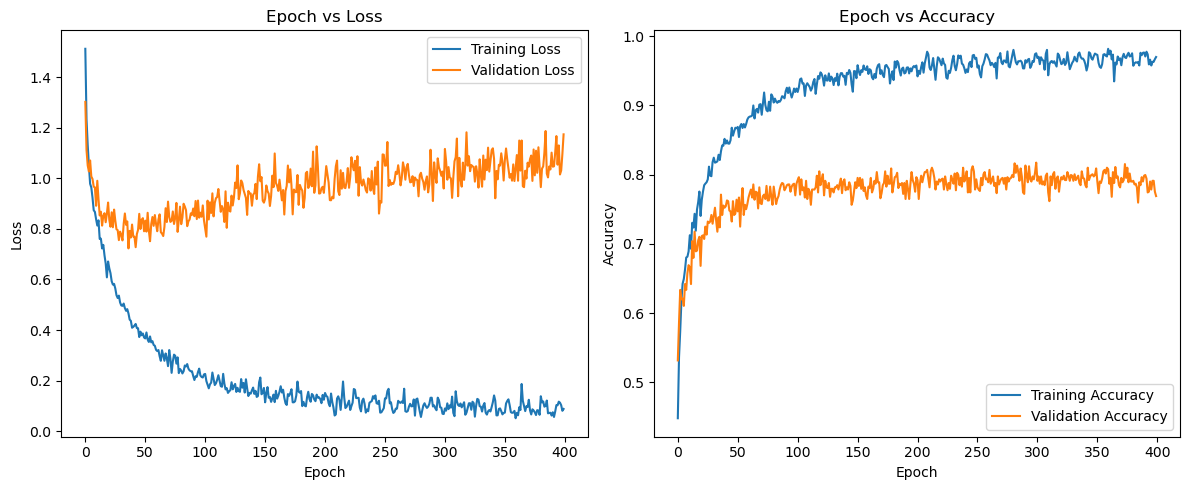

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
train_loss, train_accuracy = model.evaluate(x_train, y_train, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 97.70%
Test Accuracy: 74.56%


6/6 [==============================] - 0s 2ms/step


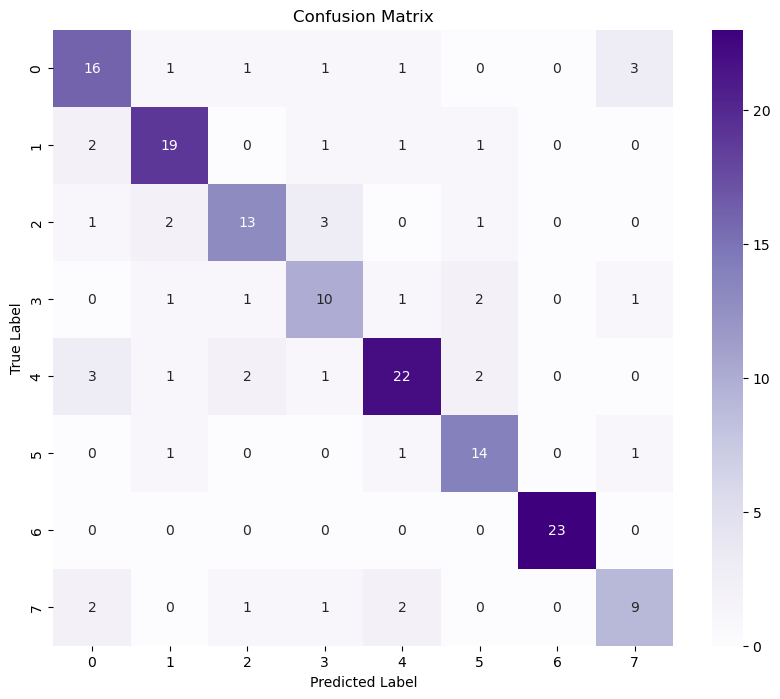

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        23
           1       0.76      0.79      0.78        24
           2       0.72      0.65      0.68        20
           3       0.59      0.62      0.61        16
           4       0.79      0.71      0.75        31
           5       0.70      0.82      0.76        17
           6       1.00      1.00      1.00        23
           7       0.64      0.60      0.62        15

    accuracy                           0.75       169
   macro avg       0.73      0.74      0.73       169
weighted avg       0.75      0.75      0.75       169



In [16]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

if len(y_test.shape) == 1 or y_test.shape[1] == 1:
    y_true = y_test  
else:
    y_true = np.argmax(y_test, axis=1)  


conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(len(np.unique(y_true)))])
print("Classification Report:")
print(class_report)